# Setup

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import defaultdict
import common_functions as cf

#Preparing Lines

In [ ]:
def modifyLine(line):
  line = line.replace("\'ll", " will")
  line = line.replace("\'re", " are")
  line = line.replace("\'m", " am")
  line = line.replace("\'d", " would")
  line = line.replace("n\'t", " not")
  line = line.replace("\'ve", " have")
  line = line.replace("\'s", " \'s")
  line = line.replace("s\'", " \'s")

  return line

#convert multiple continous dots into three continous dots

file = open('/content/well.txt', 'r')
allLines = file.readlines()
string = ""
for line in allLines:  
  string += line
string = string.replace("\n", "")
prepared_lines = []
temp_string = string[0]
for i in range(1,len(string)):
  if i< len(string)-2:
    if (string[i] =='.' or string[i]==":") and ( (string[i+1].isspace() and (not string[i+2].islower())) or (string[i-1].islower() and (string[i+1].isupper() or string[i+1]=="\""))):
      temp_string += string[i]
      prepared_lines.append(modifyLine(temp_string))
      temp_string = ""
    else:
      temp_string += string[i]   
    if string[i] =='.' and string[i+1] =='.' and string[i+2] =='.':  
      temp_string += string[i]
      prepared_lines.append(modifyLine(temp_string))
      temp_string = ""
      i=i+2
  else:
    if string[i] =='.':
      temp_string += string[i]
      prepared_lines.append(modifyLine(temp_string))
      temp_string = ""
    else:
      temp_string += string[i]

In [ ]:
def preparelines(string):

  string = string.replace("\n", "")
  prepared_lines = []
  temp_string = string[0]
  for i in range(1,len(string)):
    if i< len(string)-2:
      if (string[i] =='.' or string[i]==":") and ( (string[i+1].isspace() and (not string[i+2].islower())) or (string[i-1].islower() and (string[i+1].isupper() or string[i+1]=="\""))):
        temp_string += string[i]
        prepared_lines.append(modifyLine(temp_string))
        temp_string = ""
      else:
        temp_string += string[i]   
      if string[i] =='.' and string[i+1] =='.' and string[i+2] =='.':  
        temp_string += string[i]
        prepared_lines.append(modifyLine(temp_string))
        temp_string = ""
        i=i+2
    else:
      if string[i] =='.':
        temp_string += string[i]
        prepared_lines.append(modifyLine(temp_string))
        temp_string = ""
      else:
        temp_string += string[i]
  return prepared_lines

# Ruining the grammer

In [ ]:
verb_forms_df = pd.read_csv("verbs.txt")
verb_forms_to_simple_form = defaultdict(list)

a = verb_forms_df["PresentTense"].str.lower()
b = verb_forms_df["PastTense"].str.lower()
c = verb_forms_df["PastParticiple"].str.lower()
d = verb_forms_df["PresentParticiple"].str.lower()

def ruin_grammer(line):
  for i, word in enumerate(b):
    line = line.replace(" "+word+" "," "+a[i]+" ")
  for i, word in enumerate(c):
    line = line.replace(" "+word+" "," "+a[i]+" ")
  for i, word in enumerate(d):
    line = line.replace(" "+word+" "," "+a[i]+" ")
  line = line.replace(" a ", " ")
  line = line.replace(" an ", " ")
  line = line.replace(" from ", " ")
  line = line.replace(" the ", " ")
  line = line.replace(" on ", " ")
  line = line.replace(" in ", " ")
  line = line.replace(" at ", " ")
  line = line.replace(" of ", " ")
  line = line.replace(" is ", " ")
  line = line.replace(" am ", " ")
  line = line.replace(" to ", " ")
  line = line.replace(" was ", " ")
  line = line.replace(" were ", " ")
  line = line.replace(" it ", " ")
  line = line.replace(" can ", " ")
  line = line.replace(" your ", " you ")
  return line

# Dataset with context

In [ ]:
# assuming prepared lines are modified and standardized 

MAX_TOKENS = 128

train_context=[] 
train_input=[] 
train_target = []

In [ ]:
def data_with_context(prepared_lines):

  context = ""
  for i, line in enumerate(prepared_lines):
    temp_context = ""
    train_context.append(context)
    train_input.append(ruin_grammer(line))
    overflow = 2 + len(context.split()) + len(line.split()) - MAX_TOKENS
    if overflow<0:
      overflow = 0
    splits = context.split()
    for index in range(overflow, len(splits)):
      temp_context += splits[index]+" "
    context = temp_context + line
    train_target.append(line)  

# Making dataset with books 

In [ ]:
cf.unzip_data("/content/drive/MyDrive/literature.zip")

import pandas as pd
import sqlite3
import sqlalchemy 

try:
    conn = sqlite3.connect("books.db")    
except Exception as e:
    print(e)

#Now in order to read in pandas dataframe we need to know table name
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
#print(f"Table Name : {cursor.fetchall()}")

df = pd.read_sql_query('SELECT * FROM text_files', conn)
meow = df.iloc[0]["text"]

conn.close()

In [ ]:
data_with_context(prepared_lines)
for i in range(100, len(df)-100):
  text = df.iloc[i]["text"]
  temp = text.splitlines()
  string = ""
  for line in temp:
    if line != '':
      string = string + " " +line

  prepared_lines = preparelines(string)
  data_with_context(prepared_lines)

In [ ]:
train_context = train_context[:1950000] 
train_input = train_input[:1950000] 
train_target = train_target[:1950000] 

f_c= open(r'/content/drive/MyDrive/train_context', 'w')
f_i= open(r'/content/drive/MyDrive/train_input', 'w')
f_t= open(r'/content/drive/MyDrive/train_target', 'w')

for element in train_context:
    f_c.write(element + "\n")

for element in train_input:
    f_i.write(element + "\n")

for element in train_target:
    f_t.write(element + "\n")

f_c.close()
f_i.close()
f_t.close()

# Close connection to sqllite

In [ ]:
conn.close()

# Testing Area

In [5]:
import tensorflow.keras as keras
import tensorflow as tf
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps = 4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model 
    self.d_model = tf.cast(self.d_model, dtype= tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = step*1.35
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

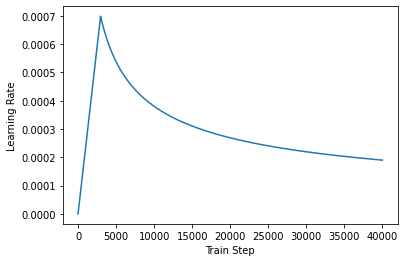

In [6]:
import matplotlib.pyplot as plt
temp_learning_rate_schedule = CustomSchedule(512)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')